In [1]:
# Mount Google drive

from google.colab import drive
drive.mount('/content/gdrive')
!ln -s /content/gdrive/MyDrive /mydrive
%cd /mydrive/satellite_images/diffusers/

# Install python packages and dependencies
# Ignore pip error for now
!pip install .

Mounted at /content/gdrive
/content/gdrive/MyDrive/satellite_images/diffusers
Processing /content/gdrive/MyDrive/satellite_images/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.6/62.6 kB 5.7 MB/s eta 0:00:00
  Created wheel for diffusers: filename=diffusers-0.30.0.dev0-py3-none-any.whl size=2209968 sha256=853bac77da039da8b3e6fa6c135c4b3dbf816b8ff42dc294647b926dfd0c1a58
  Stored in directory: /tmp/pip-ephem-wheel-cache-uzr9dpwn/wheels/fc/84/1b/ca6d366a271922ef0c65f5bbbfb0c2869095a047aea4c00a4b
Successfully built diffusers
  Attempting uninstall: requests
    Found existing installation: requests 2.32.3
    Uninstalling requests-2.32.3:
      Successfully uninstalled requests-2.32.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency c

In [2]:
# Install more package dependencies
%cd /content/gdrive/MyDrive/satellite_images/diffusers/examples/consistency_distillation
!pip install -r requirements.txt

/content/gdrive/MyDrive/satellite_images/diffusers/examples/consistency_distillation
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x8

In [3]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [4]:
#%cd /mydrive/satellite_images/diffusers/
#from utils import parse_args, train_student

import sys, importlib
import torch
sys.path.append('/mydrive/satellite_images/diffusers/')
utils = importlib.import_module('utils')
from utils import parse_args, train_student

args = parse_args()
args.push_to_hub = False
args.gradient_checkpointing = False
args.tracker_project_name = "super_resolution_distillation"

# hyper parameter for distillation
#args.loss_type = "l2"
#args.num_ddim_timesteps = 40
#timestep_scaling_factor = 20
#train_student_model(args)

/usr/local/lib/python3.10/dist-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_outputs import Transformer2DModelOutput`, instead.
  deprecate("Transformer2DModelOutput", "1.0.0", deprecation_message)


In [5]:
#Load LDM consistency models

#%cd /mydrive/satellite_images/diffusers/
pipeline_ldm_consistency_sr = importlib.import_module('pipeline_ldm_consistency_sr')
from pipeline_ldm_consistency_sr import LDMConsistencySRPipeline
pipeline = LDMConsistencySRPipeline() #.from_pretrained("CompVis/ldm-super-resolution-4x-openimages")
UNET_PATH = "/content/gdrive/MyDrive/satellite_images/diffusers/models/con_unet_model_080824.pt"
VQVAE_PATH = "/content/gdrive/MyDrive/satellite_images/diffusers/models/con_vqvae_model_080824.pt"

# Use CUDA/GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline.to(device)
pipeline.vqvae.load_state_dict(torch.load(VQVAE_PATH))
pipeline.unet.load_state_dict(torch.load(UNET_PATH))
pipeline.vqvae.to(device)
pipeline.unet.to(device)


UNet2DModel(
  (conv_in): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=160, out_features=640, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=640, out_features=640, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 160, eps=1e-05, affine=True)
          (conv1): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=640, out_features=160, bias=True)
          (norm2): GroupNorm(32, 160, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(16

In [6]:
from datasets import load_dataset
import torch, os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from PIL import ImageFilter
#dataset = load_dataset("mattymchen/celeba-hq", split='validation')

#Load satellite images
dataset = load_dataset("satellite-image-deep-learning/DOTAv2", split='train')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

In [7]:

from torchvision import transforms

# Image transforms for dataset
def transform(example, resolution=512):

# crop if size greater than 512 x 512
  def crop_normalize(image):
    # get crop coordinates and crop image
    (w,h) = image.size
    resolution = 512

    if (w < resolution or h < resolution):
      if (w<=h):
        image = TF.crop(image,0,0,w,w)
      else:
        image = TF.crop(image,0,0,h,h)

      image = TF.resize(image, (resolution, resolution))
    else:
      c_top, c_left, _, _ = transforms.RandomCrop.get_params(image, output_size=(resolution, resolution))
      image = TF.crop(image, c_top, c_left, resolution, resolution)

    image = TF.to_tensor(image)
    image = TF.normalize(image, [0.5], [0.5])
    return image

# Downsize by 4x4
  def downsize(image,resolution=512):
    image = TF.resize(image, (resolution//4, resolution//4))
    #image = TF.normalize(image, [0.5], [0.5])
    return image

    # image to tensor and normalize
  example["image"] = [crop_normalize(img) for img in example["image"]]
  example["lr_image"] = [downsize(img) for img in example["image"]]

  return example


# create evaluation set
dataset = dataset.with_transform(transform)
#train_dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
eval_dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

In [10]:
# Inference with 4 steps
# DDPM would need 100 steps
import numpy as np
num_inference_steps = 4
ref_images = []
out_sr_images = []
out_lr_images = []
int_images = []
from pipeline_ldm_consistency_sr import numpy_to_pil
device = 'cuda' if torch.cuda.is_available() else 'cpu'
pipeline.vqvae.to(device)

pipeline.unet.to(device)
pipeline.to(device)


def torch_to_pil(image):
    image = torch.clamp(image, -1.0, 1.0)
    image = image / 2 + 0.5
    image = image.cpu().permute(0, 2, 3, 1).detach().numpy()
    image = numpy_to_pil(image)
    return image

init_img = np.random.rand(512, 512, 3)
init_img = numpy_to_pil(init_img)
for step, batch in enumerate(eval_dataloader):
    # 1. Load and process the image and text conditioning
    hr_images = batch["image"]
    lr_images = batch["lr_image"]

    sr_images = []
    for image_index in range(lr_images.shape[0]):
       (sr_image, int_img) = pipeline(lr_images[image_index:image_index+1],
                           num_inference_steps=num_inference_steps,
                           return_intermediate_images = True)
       sr_images.append(sr_image[0])

    hr_images = torch_to_pil(hr_images)
    lr_images = torch_to_pil(lr_images)


    int_img.insert(0, init_img[0])
    int_images.append(int_img)
    out_sr_images.append(sr_images)
    ref_images.append(hr_images)
    out_lr_images.append(lr_images)
    if step == 8:
       break
int_images = np.stack(int_images)
int_images = np.moveaxis(int_images,0,1)

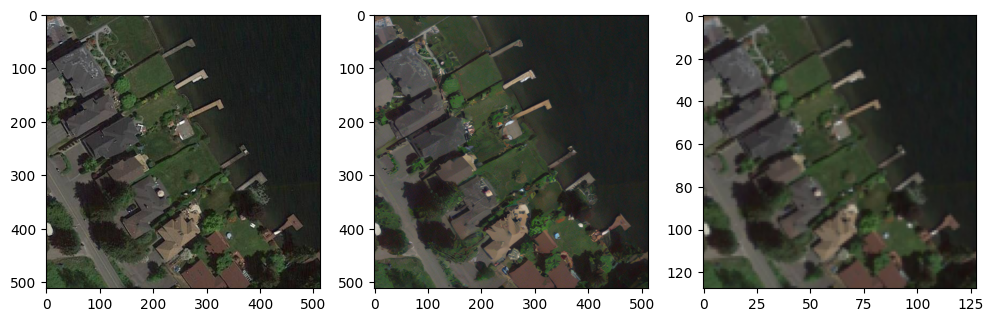

In [15]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(1,3, figsize=(12, 12))
index = 7
im_index = 0
axarr[0].imshow(ref_images[index][im_index] )
axarr[1].imshow(out_sr_images[index][im_index] )
axarr[2].imshow((out_lr_images[index][im_index]))

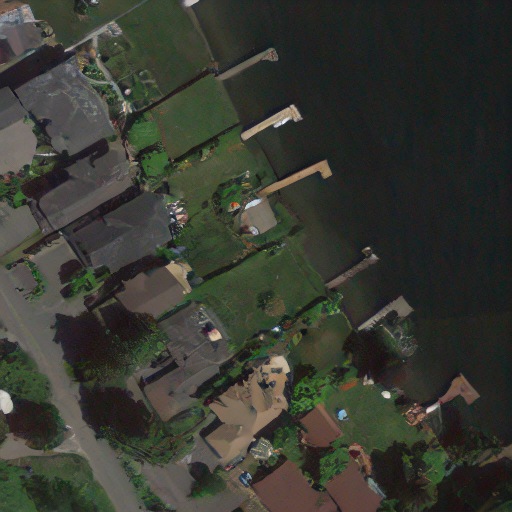

In [16]:
# Output from consistency model with 4x4 improvement in resolution
out_sr_images[index][im_index]

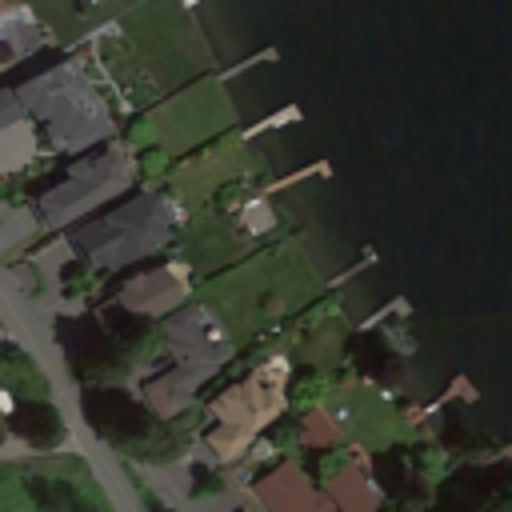

In [17]:
# Low resolution image - input to the model
out_lr_images[index][im_index].resize((512,512))